# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_sources = ['right-x', 'right-y', 'left-x', 'left-y']

for norm, source in zip(features_norm, features_sources):
    mean = asl.df['speaker'].map(df_means[source])
    std = asl.df['speaker'].map(df_std[source])
    asl.df[norm] = (asl.df[source] - mean) / std

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])
asl.df.head()
# len(asl.df.columns)

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      119      -12   164.661438  1.153232   
      1          113        9      119      -12   164.661438  1.153232   
      2          113        9      119      -12   164.661438  1.153232   
      3          113        9      119      -12   164.661438  1.153232   
      4          113        9      119      -12   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly   polar-rr  polar-rtheta  \
video frame                                                          
98    0      1.663433 -0.891199  0.741835  113.35784      0.079478   
      1      1.663433 -0.891199  0.741835  113.35784      0.079478   
      2      1.663433 -0.891199  0.741835  113.35784      0.079478   
      3      1.663433 -0.891199  0.741835  113.35784      0.079478   
      4      1.663433 -0.891199  0.741835  113.35784      0.079478   

               polar-lr  polar-ltheta  
video frame                            
98    0      119.603512     -0.100501  
      1      119.603512     -0.100501  
      2      119.603512     -0.100501  
      3      119.603512     -0.100501  
      4      119.603512     -0.100501

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0, None, 0, False, None, None)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0, None, 0, False, None, None)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0, None, 0, False, None, None)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0, None, 0, False, None, None)
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 24 columns]

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
func = 'delta-c'
features_c_delta = []
features_cross = ['cross-grnd-xx', 'cross-grnd-xy', 'cross-grnd-yx', 'cross-grnd-yy']
asl.df['cross-grnd-xx'] = asl.df['grnd-rx'] - asl.df['grnd-lx']
asl.df['cross-grnd-xy'] = asl.df['grnd-rx'] - asl.df['grnd-ly']
asl.df['cross-grnd-yx'] = asl.df['grnd-rx'] - asl.df['grnd-ly']
asl.df['cross-grnd-yy'] = asl.df['grnd-ry'] - asl.df['grnd-ly']
for feature in features_ground + features_polar + features_cross:
    new_feat = func+'-'+feature
    asl.df[new_feat] = asl.df[feature].diff().fillna(0, None, 0, False, None, None)
    features_c_delta.append(new_feat)

# Feature Scaling
df_mins = asl.df.groupby('speaker').min()
df_maxs = asl.df.groupby('speaker').max()

features_min = []
features_max = []
for feature in features_c_delta + features_ground + features_polar + features_cross:
    # we could avoid this copypasta, but it will be same as readable and probably less easy to read
    func = 'min'
    new_feat = func+'-'+feature
    asl.df[new_feat] = asl.df['speaker'].map(df_mins[feature], na_action=None)
    features_min.append(new_feat)
    func = 'max'
    new_feat = func+'-'+feature
    asl.df[new_feat] = asl.df['speaker'].map(df_maxs[feature], na_action=None)
    features_max.append(new_feat)

func = 'rescale'
features_rescaled = []
for feature in features_c_delta:
    new_feat = func+'-'+feature
    asl.df[new_feat] = ( asl.df[feature] - asl.df['min-'+feature]) / ((asl.df['max-'+feature])-asl.df['min-'+feature])
    features_rescaled.append(new_feat)

df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

func = 'normalize'
featuren_norm = []
# Normalization X - mean / std
for feature in features_rescaled:
    new_feat = func+'-'+feature
    mean = asl.df['speaker'].map(df_means[feature])
    std = asl.df['speaker'].map(df_std[feature])
    asl.df[new_feat] = (asl.df[feature] - mean) / std
    featuren_norm.append(new_feat)
  
features_custom = featuren_norm + features_rescaled + features_c_delta

asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  \
video frame                              
98    0          113        9      119   
      1          113        9      119   
      2          113        9      119   
      3          113        9      119   
      4          113        9      119   

                              ...                     \
video frame                   ...                      
98    0                       ...                      
      1                       ...                      
      2                       ...                      
      3                       ...                      
      4                       ...                      

             normalize-rescale-delta-c-grnd-lx  \
video frame                                      
98    0                               0.049186   
      1                               0.049186   
      2                               0.049186   
      3                               0.049186   
      4                               0.049186   

             normalize-rescale-delta-c-grnd-ly  \
video frame                                      
98    0                               0.041164   
      1                               0.041164   
      2                               0.041164   
      3                               0.041164   
      4                               0.041164   

             normalize-rescale-delta-c-polar-rr  \
video frame                                       
98    0                                0.039727   
      1                                0.039727   
      2                                0.039727   
      3                                0.039727   
      4                                0.039727   

             normalize-rescale-delta-c-polar-rtheta  \
video frame                                           
98    0                                   -0.008734   
      1                                   -0.008734   
      2                                   -0.008734   
      3                                   -0.008734   
      4                                   -0.008734   

             normalize-rescale-delta-c-polar-lr  \
video frame                                       
98    0                                0.042878   
      1                                0.042878   
      2                                0.042878   
      3                                0.042878   
      4                                0.042878   

             normalize-rescale-delta-c-polar-ltheta  \
video frame                                           
98    0                                    0.030803   
      1                                    0.030803   
      2                                    0.030803   
      3                                    0.030803   
      4                                    0.030803   

             normalize-rescale-delta-c-cross-grnd-xx  \
video frame                                            
98    0                                    -0.047697   
      1                                    -0.047697   
      2                                    -0.047697   
      3                                    -0.047697   
      4                                    -0.047697   

             normalize-rescale-delta-c-cross-grnd-xy  \
video frame                                            
98    0                                    -0.047543   
      1                                    -0.047543   

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
## Features selection
In the beginning I had chosen a simple rescaling of the ground features, this gave to the final recognizer really a little advantage over the other features. So I decided to experiment on a lot of variations.
In the end I decided to keep both the absolute spatial coordinates relative to the nose (ground) and the polar coordinates.

## Cross ground
I added a correlation between right and left hand, with 2 features representing the difference from the two hands in the two axis. This should represent the situations when the hands get close together of go far away.

## Deltas
From every feature represented by those 8 features I realized that the deltas seemed to be the most reliable source, so I applied first of all deltas to all my chosen set of features. I decided to apply this transformation as first to keep the dimensions real before any normalization.

## Rescale
Secondly I rescaled the deltas, to have an ideal range of [-1, 1]. Rescaling is known to improve gradient descent related techniques.

## Normalization
In the end I applied also normalization, in order to center the mean to 0 and to calculate how much any variable moved from that mean. 

It was really weird to realize that rescaling and then normalize gave me worst performances, I improved them a lot by adding non-delta to the features

This combination was the one that gave me most boost in performances, probably also because I never dropped previous calculations, and everytime I added more informations from where the HMM could learn how to represent this world.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.061s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_rescaled)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = 4286.40857711277


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 0.5924584   0.47802469  0.26863572  0.26746415  0.47240024  0.79054023
  0.19261129  0.40112922  0.71853694  0.6777196   0.6777196   0.52958025]
variance =  [ 0.00063433  0.00039969  0.00155169  0.0012621   0.00040475  0.00018399
  0.00155447  0.00166774  0.0011056   0.00127474  0.00127474  0.00049271]

hidden state #1
mean =  [ 0.30948075  0.58053544  0.75614861  0.73056638  0.57379927  0.27320847
  0.73007937  0.51264016  0.31954403  0.27320125  0.27320125  0.43224858]
variance =  [ 0.00206185  0.00038045  0.00231393  0.00130933  0.00034262  0.00126727
  0.00146642  0.00702911  0.00339791  0.0015328   0.0015328   0.00052787]

hidden state #2
mean =  [ 0.32804233  0.48878205  0.58025682  0.56819518  0.48788839  0.68923368
  0.58732859  0.53583664  0.42525371  0.49212598  0.49212598  0.46133412]
variance =  [ 0.00202668  0.00055252  0.00240726  0.00192547  0.0005152   0.00031579
  0.00207171  0.0143658   0.002977

##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword,3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028621


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [19]:
%matplotlib inline

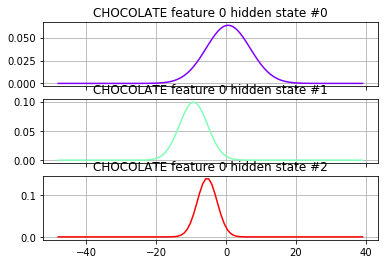

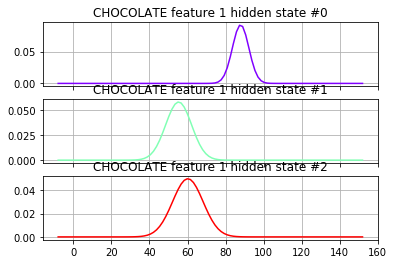

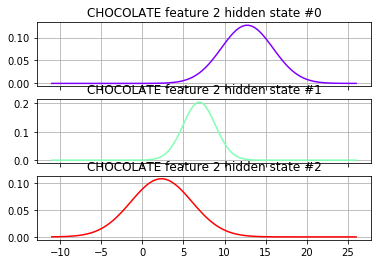

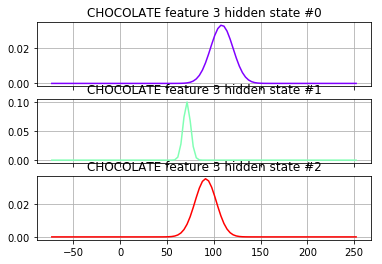

In [20]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [21]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_rescaled)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [22]:
from sklearn.model_selection import KFold

training = asl.build_training(features_rescaled) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [23]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [24]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

states = []
times = []

In [25]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        states.append(['CV', word, model.n_components])
        times.append(['CV', word, end])
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.49096389999999995 seconds
Training complete for BOOK with 6 states with time 6.331613 seconds
Training complete for VEGETABLE with 5 states with time 1.9538817999999996 seconds
Training complete for FUTURE with 4 states with time 10.821866400000001 seconds
Training complete for JOHN with 14 states with time 110.1402582 seconds


In [26]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        states.append(['BIC', word, model.n_components])
        times.append(['BIC', word, end])
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.477655000000027 seconds
Training complete for BOOK with 6 states with time 14.726410900000019 seconds
Training complete for VEGETABLE with 4 states with time 1.1244296000000418 seconds
Training complete for FUTURE with 7 states with time 2.816821599999969 seconds
Training complete for JOHN with 14 states with time 52.07434539999997 seconds


In [27]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        states.append(['DIC', word, model.n_components])
        times.append(['DIC', word, end])
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.9734190000000353 seconds
Training complete for BOOK with 11 states with time 6.501845800000012 seconds
Training complete for VEGETABLE with 15 states with time 4.986764100000016 seconds
Training complete for FUTURE with 15 states with time 5.400642599999969 seconds
Training complete for JOHN with 15 states with time 47.9017063 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

Plot Credit: http://emptypipes.org/2013/11/09/matplotlib-multicategory-barchart/


# CV
Cross Validation is a technique used in a lot of areas in Machine Learning. It basically consists in taking a data set and breaking down it into Trainig, Testing and Validating sets.

In our case we had only "Validation set" used to evaluate a model. This Validation set shifted at each round and the score was obtained by evalutating an average of the log likelihood at each rotation of the validation set. 

The splitting ratio depends on the amount of data available. In our case 3 seemed a good choice to avoid too many discards.

## Advantages
* We don't have to deal with regularization parameters

## Disadvantages
* We have to find the best splitting ratio
* Takes twice as much as time for some words
* If the complexity increases, the model is likely to overfit: this implementation rely on log likelihood only, so we don't have informations about unseen words

# BIC
Occam's Razor Principle is adopted by BIC. The principle basically says that we must choose the simplest model able to describe our context. 
To achieve so we calculate our log likelihood to try to maximize the gain, and we add a penalty computed over the model complexity. A model complexity is described by the number of hidden layers and by the number of free parameters.

## Advantages
* A lot faster than CV, slightly faster than DIC
* It avoid overfitting thanks to its penalization system
* Non sensitive to dictionary size and number of samples

## Disadvantages
* It might underfit due to penalization to complex models

# DIC
This model selection is quite expensive. We have to create all the combinations for any state (as for the other models) and for every word. In our case we had few words, but is we try to include thousands of words the problem will slow down dramatically.

The princple here is to discriminate one word agains other competing words. This model focus on competitive approach, that results in good performances compared to the other approaches, but it have theoretical limitations.
https://projecteuclid.org/download/pdf_1/euclid.ba/1340370933

## Advantages
* performances good in this limited context
* decreased error rate with some feature set

## Disadvantages
* theoretical limitations
* the penalty term is invariant to reparametrization
* is not based on proper predictive criterion
http://avansp.github.io/2014/11/02/DIC-AIC-BIC.html


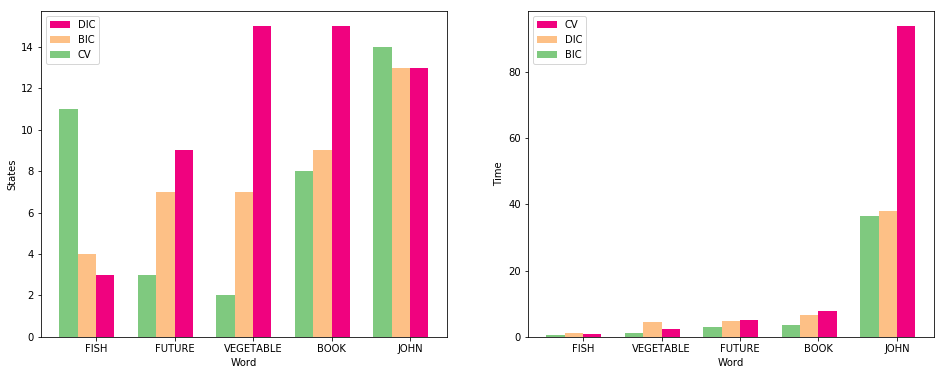

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator as o

import numpy as np

states = np.array([
    ['CV', 'FISH', 11],
    ['CV', 'BOOK', 8],
    ['CV', 'VEGETABLE', 2],
    ['CV', 'FUTURE', 3],
    ['CV', 'JOHN', 14],
    ['BIC', 'FISH', 4],
    ['BIC', 'BOOK', 9],
    ['BIC', 'VEGETABLE', 7],
    ['BIC', 'FUTURE', 7],
    ['BIC', 'JOHN', 13],
    ['DIC', 'FISH', 3],
    ['DIC', 'BOOK', 15],
    ['DIC', 'VEGETABLE', 15],
    ['DIC', 'FUTURE', 9],
    ['DIC', 'JOHN', 13]])
times = np.array([
    ['CV', 'FISH', 0.7844209479953861],
    ['CV', 'BOOK', 7.8218160930046],
    ['CV', 'VEGETABLE', 2.4220133869966958],
    ['CV', 'FUTURE', 5.183210510003846],
    ['CV', 'JOHN', 93.81622445800167],
    ['BIC', 'FISH', 0.6003014560046722],
    ['BIC', 'BOOK', 3.5011018610020983],
    ['BIC', 'VEGETABLE', 1.1156856599991443],
    ['BIC', 'FUTURE', 3.089726657999563],
    ['BIC', 'JOHN', 36.35667467500025],
    ['DIC', 'FISH', 1.0511226210001041],
    ['DIC', 'BOOK', 6.488433416001499],
    ['DIC', 'VEGETABLE', 4.506588972995814],
    ['DIC', 'FUTURE', 4.7100966930011055],
    ['DIC', 'JOHN', 37.856232058002206]])

fig = plt.figure(figsize=(16, 6))
s = fig.add_subplot(121)
t = fig.add_subplot(122)

def barplot(ax, dpoints, ylabel, xlabel):
    space = 0.3
    # plt.setp(plt.xticks()[1], rotation=90)
    # Aggregate the conditions and the categories according to their
    # mean values
    conditions = [(c, np.mean(dpoints[dpoints[:,0] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,0])]
    categories = [(c, np.mean(dpoints[dpoints[:,1] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,1])]
    
    # sort the conditions, categories and data so that the bars in
    # the plot will be ordered by category and condition
    conditions = [c[0] for c in sorted(conditions, key=o.itemgetter(1))]
    categories = [c[0] for c in sorted(categories, key=o.itemgetter(1))]
    
    dpoints = np.array(sorted(dpoints, key=lambda x: categories.index(x[1])))

    n = len(conditions)

    width = (1 - space) / (len(conditions))

    for i,cond in enumerate(conditions):
        indeces = range(1, len(categories)+1)
        vals = dpoints[dpoints[:,0] == cond][:,2].astype(np.float)
        pos = [j - (1 - space) / 2. + i * width for j in range(1,len(categories)+1)]
        ax.bar(pos, vals, width=width, label=cond, color=cm.Accent(float(i) / n))
    ax.set_xticks(indeces)
    ax.set_xticklabels(categories)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    
barplot(s, states, "States", "Word")
barplot(t, times, "Time", "Word")
plt.show()



<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [29]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 81.414s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [30]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_custom, SelectorConstant) # Experiment with different feature sets
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [31]:
test_set = asl.build_test(features_custom)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize, wer
from asl_utils import show_errors
import json

# Static initialization to test visualization and to train ngram with probabilities
probs = json.load(open('ngram/prob.json'))
# wer and time results 
time_list = np.array([['sources', 'Constant', 32.06317462200241], ['sources', 'CV', 167.1034167209873], ['sources', 'BIC', 94.81996975799848], ['sources', 'DIC', 265.80535814700124], ['ground', 'Constant', 26.8189362980047], ['ground', 'CV', 164.37993116899452], ['ground', 'BIC', 95.38915232400177], ['ground', 'DIC', 264.75518923200434], ['delta', 'Constant', 27.640308943999116], ['delta', 'CV', 205.3085307970032], ['delta', 'BIC', 112.50598360599543], ['delta', 'DIC', 264.63634875501157], ['polar', 'Constant', 27.193732016006834], ['polar', 'CV', 176.5712317909929], ['polar', 'BIC', 108.1211148420116], ['polar', 'DIC', 300.20207869099977], ['norm', 'Constant', 28.277939751002123], ['norm', 'CV', 180.6671787410014], ['norm', 'BIC', 102.94830560799164], ['norm', 'DIC', 289.72872780599573], ['custom_cross', 'Constant', 27.01955635799095], ['custom_cross', 'CV', 188.45209775300464], ['custom_cross', 'BIC', 114.17852805899747], ['custom_cross', 'DIC', 283.80244973099616], ['custom_delta', 'Constant', 55.27959816699149], ['custom_delta', 'CV', 237.80148008999822], ['custom_delta', 'BIC', 154.1900353289966], ['custom_delta', 'DIC', 309.2467900509946], ['custom_rescaled', 'Constant', 49.34380871198664], ['custom_rescaled', 'CV', 196.18201134901028], ['custom_rescaled', 'BIC', 108.73737291300495], ['custom_rescaled', 'DIC', 292.84584637600346], ['custom_norm', 'Constant', 28.380314616006217], ['custom_norm', 'CV', 183.92486462500528], ['custom_norm', 'BIC', 102.12849851298961], ['custom_norm', 'DIC', 282.584205156003], ['custom_all', 'Constant', 126.55448491500283], ['custom_all', 'CV', 318.3281617140019], ['custom_all', 'BIC', 219.36291719898873], ['custom_all', 'DIC', 389.3932941499952], ['all', 'Constant', 188.1719429710065], ['all', 'CV', 348.6323895740061], ['all', 'BIC', 266.49638368900924], ['all', 'DIC', 435.86374439200154], ['all_base_but_norm', 'Constant', 64.0440320790076], ['all_base_but_norm', 'CV', 205.98502974600706], ['all_base_but_norm', 'BIC', 138.33257549800328], ['all_base_but_norm', 'DIC', 299.21949758300616], ['all_base_but_ground', 'Constant', 63.86340100498637], ['all_base_but_ground', 'CV', 200.90189914898656], ['all_base_but_ground', 'BIC', 137.6060614799935], ['all_base_but_ground', 'DIC', 298.7663460019976], ['all_base_but_delta', 'Constant', 62.5346828729962], ['all_base_but_delta', 'CV', 184.05417101900093], ['all_base_but_delta', 'BIC', 126.78555961699749], ['all_base_but_delta', 'DIC', 292.93993201400735], ['all_base_but_polar', 'Constant', 63.49344960600138], ['all_base_but_polar', 'CV', 201.96014755898796], ['all_base_but_polar', 'BIC', 134.4293371149979], ['all_base_but_polar', 'DIC', 296.3697175940033]])
i_time_list = np.array([['Constant', 'sources', 32.06317462200241], ['CV', 'sources', 167.1034167209873], ['BIC', 'sources', 94.81996975799848], ['DIC', 'sources', 265.80535814700124], ['Constant', 'ground', 26.8189362980047], ['CV', 'ground', 164.37993116899452], ['BIC', 'ground', 95.38915232400177], ['DIC', 'ground', 264.75518923200434], ['Constant', 'delta', 27.640308943999116], ['CV', 'delta', 205.3085307970032], ['BIC', 'delta', 112.50598360599543], ['DIC', 'delta', 264.63634875501157], ['Constant', 'polar', 27.193732016006834], ['CV', 'polar', 176.5712317909929], ['BIC', 'polar', 108.1211148420116], ['DIC', 'polar', 300.20207869099977], ['Constant', 'norm', 28.277939751002123], ['CV', 'norm', 180.6671787410014], ['BIC', 'norm', 102.94830560799164], ['DIC', 'norm', 289.72872780599573], ['Constant', 'custom_cross', 27.01955635799095], ['CV', 'custom_cross', 188.45209775300464], ['BIC', 'custom_cross', 114.17852805899747], ['DIC', 'custom_cross', 283.80244973099616], ['Constant', 'custom_delta', 55.27959816699149], ['CV', 'custom_delta', 237.80148008999822], ['BIC', 'custom_delta', 154.1900353289966], ['DIC', 'custom_delta', 309.2467900509946], ['Constant', 'custom_rescaled', 49.34380871198664], ['CV', 'custom_rescaled', 196.18201134901028], ['BIC', 'custom_rescaled', 108.73737291300495], ['DIC', 'custom_rescaled', 292.84584637600346], ['Constant', 'custom_norm', 28.380314616006217], ['CV', 'custom_norm', 183.92486462500528], ['BIC', 'custom_norm', 102.12849851298961], ['DIC', 'custom_norm', 282.584205156003], ['Constant', 'custom_all', 126.55448491500283], ['CV', 'custom_all', 318.3281617140019], ['BIC', 'custom_all', 219.36291719898873], ['DIC', 'custom_all', 389.3932941499952], ['Constant', 'all', 188.1719429710065], ['CV', 'all', 348.6323895740061], ['BIC', 'all', 266.49638368900924], ['DIC', 'all', 435.86374439200154], ['Constant', 'all_base_but_norm', 64.0440320790076], ['CV', 'all_base_but_norm', 205.98502974600706], ['BIC', 'all_base_but_norm', 138.33257549800328], ['DIC', 'all_base_but_norm', 299.21949758300616], ['Constant', 'all_base_but_ground', 63.86340100498637], ['CV', 'all_base_but_ground', 200.90189914898656], ['BIC', 'all_base_but_ground', 137.6060614799935], ['DIC', 'all_base_but_ground', 298.7663460019976], ['Constant', 'all_base_but_delta', 62.5346828729962], ['CV', 'all_base_but_delta', 184.05417101900093], ['BIC', 'all_base_but_delta', 126.78555961699749], ['DIC', 'all_base_but_delta', 292.93993201400735], ['Constant', 'all_base_but_polar', 63.49344960600138], ['CV', 'all_base_but_polar', 201.96014755898796], ['BIC', 'all_base_but_polar', 134.4293371149979], ['DIC', 'all_base_but_polar', 296.3697175940033]])
wer_list = np.array([['sources', 'Constant', 0.6460674157303371], ['sources', 'CV', 0.6741573033707865], ['sources', 'BIC', 0.6123595505617978], ['sources', 'DIC', 0.6404494382022472], ['ground', 'Constant', 0.6685393258426966], ['ground', 'CV', 0.5337078651685393], ['ground', 'BIC', 0.5561797752808989], ['ground', 'DIC', 0.5730337078651685], ['delta', 'Constant', 0.6404494382022472], ['delta', 'CV', 0.6179775280898876], ['delta', 'BIC', 0.6123595505617978], ['delta', 'DIC', 0.6292134831460674], ['polar', 'Constant', 0.6179775280898876], ['polar', 'CV', 0.5617977528089888], ['polar', 'BIC', 0.5449438202247191], ['polar', 'DIC', 0.5449438202247191], ['norm', 'Constant', 0.6235955056179775], ['norm', 'CV', 0.6067415730337079], ['norm', 'BIC', 0.6292134831460674], ['norm', 'DIC', 0.5955056179775281], ['custom_cross', 'Constant', 0.702247191011236], ['custom_cross', 'CV', 0.6123595505617978], ['custom_cross', 'BIC', 0.601123595505618], ['custom_cross', 'DIC', 0.6235955056179775], ['custom_delta', 'Constant', 0.702247191011236], ['custom_delta', 'CV', 0.6067415730337079], ['custom_delta', 'BIC', 0.5842696629213483], ['custom_delta', 'DIC', 0.6235955056179775], ['custom_rescaled', 'Constant', 0.6404494382022472], ['custom_rescaled', 'CV', 0.4887640449438202], ['custom_rescaled', 'BIC', 0.5112359550561798], ['custom_rescaled', 'DIC', 0.5056179775280899], ['custom_norm', 'Constant', 0.6235955056179775], ['custom_norm', 'CV', 0.6067415730337079], ['custom_norm', 'BIC', 0.6292134831460674], ['custom_norm', 'DIC', 0.5955056179775281], ['custom_all', 'Constant', 0.6797752808988764], ['custom_all', 'CV', 0.550561797752809], ['custom_all', 'BIC', 0.5617977528089888], ['custom_all', 'DIC', 0.5842696629213483], ['all', 'Constant', 0.5112359550561798], ['all', 'CV', 0.4943820224719101], ['all', 'BIC', 0.4606741573033708], ['all', 'DIC', 0.47191011235955055], ['all_base_but_norm', 'Constant', 0.5730337078651685], ['all_base_but_norm', 'CV', 0.5337078651685393], ['all_base_but_norm', 'BIC', 0.5280898876404494], ['all_base_but_norm', 'DIC', 0.5280898876404494], ['all_base_but_ground', 'Constant', 0.5674157303370787], ['all_base_but_ground', 'CV', 0.5168539325842697], ['all_base_but_ground', 'BIC', 0.5168539325842697], ['all_base_but_ground', 'DIC', 0.5280898876404494], ['all_base_but_delta', 'Constant', 0.6067415730337079], ['all_base_but_delta', 'CV', 0.5898876404494382], ['all_base_but_delta', 'BIC', 0.5224719101123596], ['all_base_but_delta', 'DIC', 0.5168539325842697], ['all_base_but_polar', 'Constant', 0.5337078651685393], ['all_base_but_polar', 'CV', 0.5], ['all_base_but_polar', 'BIC', 0.5], ['all_base_but_polar', 'DIC', 0.5280898876404494]])
i_wer_list = np.array([['Constant', 'sources', 0.6460674157303371], ['CV', 'sources', 0.6741573033707865], ['BIC', 'sources', 0.6123595505617978], ['DIC', 'sources', 0.6404494382022472], ['Constant', 'ground', 0.6685393258426966], ['CV', 'ground', 0.5337078651685393], ['BIC', 'ground', 0.5561797752808989], ['DIC', 'ground', 0.5730337078651685], ['Constant', 'delta', 0.6404494382022472], ['CV', 'delta', 0.6179775280898876], ['BIC', 'delta', 0.6123595505617978], ['DIC', 'delta', 0.6292134831460674], ['Constant', 'polar', 0.6179775280898876], ['CV', 'polar', 0.5617977528089888], ['BIC', 'polar', 0.5449438202247191], ['DIC', 'polar', 0.5449438202247191], ['Constant', 'norm', 0.6235955056179775], ['CV', 'norm', 0.6067415730337079], ['BIC', 'norm', 0.6292134831460674], ['DIC', 'norm', 0.5955056179775281], ['Constant', 'custom_cross', 0.702247191011236], ['CV', 'custom_cross', 0.6123595505617978], ['BIC', 'custom_cross', 0.601123595505618], ['DIC', 'custom_cross', 0.6235955056179775], ['Constant', 'custom_delta', 0.702247191011236], ['CV', 'custom_delta', 0.6067415730337079], ['BIC', 'custom_delta', 0.5842696629213483], ['DIC', 'custom_delta', 0.6235955056179775], ['Constant', 'custom_rescaled', 0.6404494382022472], ['CV', 'custom_rescaled', 0.4887640449438202], ['BIC', 'custom_rescaled', 0.5112359550561798], ['DIC', 'custom_rescaled', 0.5056179775280899], ['Constant', 'custom_norm', 0.6235955056179775], ['CV', 'custom_norm', 0.6067415730337079], ['BIC', 'custom_norm', 0.6292134831460674], ['DIC', 'custom_norm', 0.5955056179775281], ['Constant', 'custom_all', 0.6797752808988764], ['CV', 'custom_all', 0.550561797752809], ['BIC', 'custom_all', 0.5617977528089888], ['DIC', 'custom_all', 0.5842696629213483], ['Constant', 'all', 0.5112359550561798], ['CV', 'all', 0.4943820224719101], ['BIC', 'all', 0.4606741573033708], ['DIC', 'all', 0.47191011235955055], ['Constant', 'all_base_but_norm', 0.5730337078651685], ['CV', 'all_base_but_norm', 0.5337078651685393], ['BIC', 'all_base_but_norm', 0.5280898876404494], ['DIC', 'all_base_but_norm', 0.5280898876404494], ['Constant', 'all_base_but_ground', 0.5674157303370787], ['CV', 'all_base_but_ground', 0.5168539325842697], ['BIC', 'all_base_but_ground', 0.5168539325842697], ['DIC', 'all_base_but_ground', 0.5280898876404494], ['Constant', 'all_base_but_delta', 0.6067415730337079], ['CV', 'all_base_but_delta', 0.5898876404494382], ['BIC', 'all_base_but_delta', 0.5224719101123596], ['DIC', 'all_base_but_delta', 0.5168539325842697], ['Constant', 'all_base_but_polar', 0.5337078651685393], ['CV', 'all_base_but_polar', 0.5], ['BIC', 'all_base_but_polar', 0.5], ['DIC', 'all_base_but_polar', 0.5280898876404494]])

time_list = [['sources', 'Fixed', 25.36729594499957], ['sources', 'CV', 160.50836169499962], ['sources', 'BIC', 89.33092050100004], ['sources', 'DIC', 250.9740911909994], ['ground', 'Fixed', 25.301494151000043], ['ground', 'CV', 158.9503040189993], ['ground', 'BIC', 92.84207564900044], ['ground', 'DIC', 254.25845965200006], ['delta', 'Fixed', 28.024467829999594], ['delta', 'CV', 205.63733504599986], ['delta', 'BIC', 107.79889982399982], ['delta', 'DIC', 253.50780088100055], ['polar', 'Fixed', 26.008226170999478], ['polar', 'CV', 171.00171567199868], ['polar', 'BIC', 103.61173769800007], ['polar', 'DIC', 273.06694421999964], ['norm', 'Fixed', 26.7241656039987], ['norm', 'CV', 171.0565144200009], ['norm', 'BIC', 97.84612273400126], ['norm', 'DIC', 269.7643071500006], ['custom_cross', 'Fixed', 25.245039507999536], ['custom_cross', 'CV', 176.847700418999], ['custom_cross', 'BIC', 104.19407073600087], ['custom_cross', 'DIC', 264.68252966], ['custom_delta', 'Fixed', 51.95367747799901], ['custom_delta', 'CV', 229.18920547800008], ['custom_delta', 'BIC', 145.9360285370003], ['custom_delta', 'DIC', 289.843017707999], ['custom_rescaled', 'Fixed', 47.676567340000474], ['custom_rescaled', 'CV', 184.23169966899877], ['custom_rescaled', 'BIC', 103.88352082900019], ['custom_rescaled', 'DIC', 276.2946933610001], ['custom_norm', 'Fixed', 27.055539255999975], ['custom_norm', 'CV', 170.5672465430016], ['custom_norm', 'BIC', 96.9401285010008], ['custom_norm', 'DIC', 269.87050079300025], ['custom_all', 'Fixed', 121.36161652300143], ['custom_all', 'CV', 306.28055402599966], ['custom_all', 'BIC', 213.41317988799892], ['custom_all', 'DIC', 370.9666752859994], ['all', 'Fixed', 180.532917429], ['all', 'CV', 332.0077759629985], ['all', 'BIC', 254.94317907599907], ['all', 'DIC', 418.6779283270007], ['all_base_but_norm', 'Fixed', 62.093230791999304], ['all_base_but_norm', 'CV', 197.17529949100026], ['all_base_but_norm', 'BIC', 132.69702856500044], ['all_base_but_norm', 'DIC', 286.0000852680005], ['all_base_but_ground', 'Fixed', 61.6555299319989], ['all_base_but_ground', 'CV', 193.21257530000003], ['all_base_but_ground', 'BIC', 132.50134970899853], ['all_base_but_ground', 'DIC', 285.9408960150013], ['all_base_but_delta', 'Fixed', 60.742973804999565], ['all_base_but_delta', 'CV', 177.3801616919991], ['all_base_but_delta', 'BIC', 122.68808795900077], ['all_base_but_delta', 'DIC', 283.4668032219997], ['all_base_but_polar', 'Fixed', 62.448572859000706], ['all_base_but_polar', 'CV', 194.96346237399848], ['all_base_but_polar', 'BIC', 129.78766557600102], ['all_base_but_polar', 'DIC', 283.1958563799999], ['del_pol_norm', 'Fixed', 50.30011765800009], ['del_pol_norm', 'CV', 211.64251525600048], ['del_pol_norm', 'BIC', 133.34674943400023], ['del_pol_norm', 'DIC', 278.647864044], ['pol_gr_del', 'Fixed', 49.9680661880011], ['pol_gr_del', 'CV', 199.40344893699876], ['pol_gr_del', 'BIC', 127.92746177200024], ['pol_gr_del', 'DIC', 279.2279835579975], ['cr_norm_del_pol', 'Fixed', 62.20119185799922], ['cr_norm_del_pol', 'CV', 201.14055254100094], ['cr_norm_del_pol', 'BIC', 131.93175000799965], ['cr_norm_del_pol', 'DIC', 285.15501680500165], ['cr_pol_gr_del', 'Fixed', 63.232445899000595], ['cr_pol_gr_del', 'CV', 193.98919016699801], ['cr_pol_gr_del', 'BIC', 133.3713302269971], ['cr_pol_gr_del', 'DIC', 290.8635258430004]]
i_time_list = [['Fixed', 'sources', 25.36729594499957], ['CV', 'sources', 160.50836169499962], ['BIC', 'sources', 89.33092050100004], ['DIC', 'sources', 250.9740911909994], ['Fixed', 'ground', 25.301494151000043], ['CV', 'ground', 158.9503040189993], ['BIC', 'ground', 92.84207564900044], ['DIC', 'ground', 254.25845965200006], ['Fixed', 'delta', 28.024467829999594], ['CV', 'delta', 205.63733504599986], ['BIC', 'delta', 107.79889982399982], ['DIC', 'delta', 253.50780088100055], ['Fixed', 'polar', 26.008226170999478], ['CV', 'polar', 171.00171567199868], ['BIC', 'polar', 103.61173769800007], ['DIC', 'polar', 273.06694421999964], ['Fixed', 'norm', 26.7241656039987], ['CV', 'norm', 171.0565144200009], ['BIC', 'norm', 97.84612273400126], ['DIC', 'norm', 269.7643071500006], ['Fixed', 'custom_cross', 25.245039507999536], ['CV', 'custom_cross', 176.847700418999], ['BIC', 'custom_cross', 104.19407073600087], ['DIC', 'custom_cross', 264.68252966], ['Fixed', 'custom_delta', 51.95367747799901], ['CV', 'custom_delta', 229.18920547800008], ['BIC', 'custom_delta', 145.9360285370003], ['DIC', 'custom_delta', 289.843017707999], ['Fixed', 'custom_rescaled', 47.676567340000474], ['CV', 'custom_rescaled', 184.23169966899877], ['BIC', 'custom_rescaled', 103.88352082900019], ['DIC', 'custom_rescaled', 276.2946933610001], ['Fixed', 'custom_norm', 27.055539255999975], ['CV', 'custom_norm', 170.5672465430016], ['BIC', 'custom_norm', 96.9401285010008], ['DIC', 'custom_norm', 269.87050079300025], ['Fixed', 'custom_all', 121.36161652300143], ['CV', 'custom_all', 306.28055402599966], ['BIC', 'custom_all', 213.41317988799892], ['DIC', 'custom_all', 370.9666752859994], ['Fixed', 'all', 180.532917429], ['CV', 'all', 332.0077759629985], ['BIC', 'all', 254.94317907599907], ['DIC', 'all', 418.6779283270007], ['Fixed', 'all_base_but_norm', 62.093230791999304], ['CV', 'all_base_but_norm', 197.17529949100026], ['BIC', 'all_base_but_norm', 132.69702856500044], ['DIC', 'all_base_but_norm', 286.0000852680005], ['Fixed', 'all_base_but_ground', 61.6555299319989], ['CV', 'all_base_but_ground', 193.21257530000003], ['BIC', 'all_base_but_ground', 132.50134970899853], ['DIC', 'all_base_but_ground', 285.9408960150013], ['Fixed', 'all_base_but_delta', 60.742973804999565], ['CV', 'all_base_but_delta', 177.3801616919991], ['BIC', 'all_base_but_delta', 122.68808795900077], ['DIC', 'all_base_but_delta', 283.4668032219997], ['Fixed', 'all_base_but_polar', 62.448572859000706], ['CV', 'all_base_but_polar', 194.96346237399848], ['BIC', 'all_base_but_polar', 129.78766557600102], ['DIC', 'all_base_but_polar', 283.1958563799999], ['Fixed', 'del_pol_norm', 50.30011765800009], ['CV', 'del_pol_norm', 211.64251525600048], ['BIC', 'del_pol_norm', 133.34674943400023], ['DIC', 'del_pol_norm', 278.647864044], ['Fixed', 'pol_gr_del', 49.9680661880011], ['CV', 'pol_gr_del', 199.40344893699876], ['BIC', 'pol_gr_del', 127.92746177200024], ['DIC', 'pol_gr_del', 279.2279835579975], ['Fixed', 'cr_norm_del_pol', 62.20119185799922], ['CV', 'cr_norm_del_pol', 201.14055254100094], ['BIC', 'cr_norm_del_pol', 131.93175000799965], ['DIC', 'cr_norm_del_pol', 285.15501680500165], ['Fixed', 'cr_pol_gr_del', 63.232445899000595], ['CV', 'cr_pol_gr_del', 193.98919016699801], ['BIC', 'cr_pol_gr_del', 133.3713302269971], ['DIC', 'cr_pol_gr_del', 290.8635258430004]]
wer_list = [['sources', 'Fixed', 0.6460674157303371], ['sources', 'CV', 0.6741573033707865], ['sources', 'BIC', 0.6123595505617978], ['sources', 'DIC', 0.6404494382022472], ['ground', 'Fixed', 0.6685393258426966], ['ground', 'CV', 0.5337078651685393], ['ground', 'BIC', 0.5561797752808989], ['ground', 'DIC', 0.5730337078651685], ['delta', 'Fixed', 0.6404494382022472], ['delta', 'CV', 0.6179775280898876], ['delta', 'BIC', 0.6123595505617978], ['delta', 'DIC', 0.6292134831460674], ['polar', 'Fixed', 0.6179775280898876], ['polar', 'CV', 0.5617977528089888], ['polar', 'BIC', 0.5449438202247191], ['polar', 'DIC', 0.5449438202247191], ['norm', 'Fixed', 0.6235955056179775], ['norm', 'CV', 0.6067415730337079], ['norm', 'BIC', 0.6292134831460674], ['norm', 'DIC', 0.5955056179775281], ['custom_cross', 'Fixed', 0.702247191011236], ['custom_cross', 'CV', 0.6123595505617978], ['custom_cross', 'BIC', 0.601123595505618], ['custom_cross', 'DIC', 0.6235955056179775], ['custom_delta', 'Fixed', 0.702247191011236], ['custom_delta', 'CV', 0.6067415730337079], ['custom_delta', 'BIC', 0.5842696629213483], ['custom_delta', 'DIC', 0.6235955056179775], ['custom_rescaled', 'Fixed', 0.6404494382022472], ['custom_rescaled', 'CV', 0.4887640449438202], ['custom_rescaled', 'BIC', 0.5112359550561798], ['custom_rescaled', 'DIC', 0.5056179775280899], ['custom_norm', 'Fixed', 0.6235955056179775], ['custom_norm', 'CV', 0.6067415730337079], ['custom_norm', 'BIC', 0.6292134831460674], ['custom_norm', 'DIC', 0.5955056179775281], ['custom_all', 'Fixed', 0.6797752808988764], ['custom_all', 'CV', 0.550561797752809], ['custom_all', 'BIC', 0.5617977528089888], ['custom_all', 'DIC', 0.5842696629213483], ['all', 'Fixed', 0.5112359550561798], ['all', 'CV', 0.4943820224719101], ['all', 'BIC', 0.4606741573033708], ['all', 'DIC', 0.47191011235955055], ['all_base_but_norm', 'Fixed', 0.5730337078651685], ['all_base_but_norm', 'CV', 0.5337078651685393], ['all_base_but_norm', 'BIC', 0.5280898876404494], ['all_base_but_norm', 'DIC', 0.5280898876404494], ['all_base_but_ground', 'Fixed', 0.5674157303370787], ['all_base_but_ground', 'CV', 0.5168539325842697], ['all_base_but_ground', 'BIC', 0.5168539325842697], ['all_base_but_ground', 'DIC', 0.5280898876404494], ['all_base_but_delta', 'Fixed', 0.6067415730337079], ['all_base_but_delta', 'CV', 0.5898876404494382], ['all_base_but_delta', 'BIC', 0.5224719101123596], ['all_base_but_delta', 'DIC', 0.5168539325842697], ['all_base_but_polar', 'Fixed', 0.5337078651685393], ['all_base_but_polar', 'CV', 0.5], ['all_base_but_polar', 'BIC', 0.5], ['all_base_but_polar', 'DIC', 0.5280898876404494], ['del_pol_norm', 'Fixed', 0.5337078651685393], ['del_pol_norm', 'CV', 0.5168539325842697], ['del_pol_norm', 'BIC', 0.47752808988764045], ['del_pol_norm', 'DIC', 0.5112359550561798], ['pol_gr_del', 'Fixed', 0.5955056179775281], ['pol_gr_del', 'CV', 0.5224719101123596], ['pol_gr_del', 'BIC', 0.4943820224719101], ['pol_gr_del', 'DIC', 0.5449438202247191], ['cr_norm_del_pol', 'Fixed', 0.550561797752809], ['cr_norm_del_pol', 'CV', 0.4943820224719101], ['cr_norm_del_pol', 'BIC', 0.4887640449438202], ['cr_norm_del_pol', 'DIC', 0.4887640449438202], ['cr_pol_gr_del', 'Fixed', 0.5561797752808989], ['cr_pol_gr_del', 'CV', 0.550561797752809], ['cr_pol_gr_del', 'BIC', 0.5393258426966292], ['cr_pol_gr_del', 'DIC', 0.5224719101123596]]
i_wer_list = [['Fixed', 'sources', 0.6460674157303371], ['CV', 'sources', 0.6741573033707865], ['BIC', 'sources', 0.6123595505617978], ['DIC', 'sources', 0.6404494382022472], ['Fixed', 'ground', 0.6685393258426966], ['CV', 'ground', 0.5337078651685393], ['BIC', 'ground', 0.5561797752808989], ['DIC', 'ground', 0.5730337078651685], ['Fixed', 'delta', 0.6404494382022472], ['CV', 'delta', 0.6179775280898876], ['BIC', 'delta', 0.6123595505617978], ['DIC', 'delta', 0.6292134831460674], ['Fixed', 'polar', 0.6179775280898876], ['CV', 'polar', 0.5617977528089888], ['BIC', 'polar', 0.5449438202247191], ['DIC', 'polar', 0.5449438202247191], ['Fixed', 'norm', 0.6235955056179775], ['CV', 'norm', 0.6067415730337079], ['BIC', 'norm', 0.6292134831460674], ['DIC', 'norm', 0.5955056179775281], ['Fixed', 'custom_cross', 0.702247191011236], ['CV', 'custom_cross', 0.6123595505617978], ['BIC', 'custom_cross', 0.601123595505618], ['DIC', 'custom_cross', 0.6235955056179775], ['Fixed', 'custom_delta', 0.702247191011236], ['CV', 'custom_delta', 0.6067415730337079], ['BIC', 'custom_delta', 0.5842696629213483], ['DIC', 'custom_delta', 0.6235955056179775], ['Fixed', 'custom_rescaled', 0.6404494382022472], ['CV', 'custom_rescaled', 0.4887640449438202], ['BIC', 'custom_rescaled', 0.5112359550561798], ['DIC', 'custom_rescaled', 0.5056179775280899], ['Fixed', 'custom_norm', 0.6235955056179775], ['CV', 'custom_norm', 0.6067415730337079], ['BIC', 'custom_norm', 0.6292134831460674], ['DIC', 'custom_norm', 0.5955056179775281], ['Fixed', 'custom_all', 0.6797752808988764], ['CV', 'custom_all', 0.550561797752809], ['BIC', 'custom_all', 0.5617977528089888], ['DIC', 'custom_all', 0.5842696629213483], ['Fixed', 'all', 0.5112359550561798], ['CV', 'all', 0.4943820224719101], ['BIC', 'all', 0.4606741573033708], ['DIC', 'all', 0.47191011235955055], ['Fixed', 'all_base_but_norm', 0.5730337078651685], ['CV', 'all_base_but_norm', 0.5337078651685393], ['BIC', 'all_base_but_norm', 0.5280898876404494], ['DIC', 'all_base_but_norm', 0.5280898876404494], ['Fixed', 'all_base_but_ground', 0.5674157303370787], ['CV', 'all_base_but_ground', 0.5168539325842697], ['BIC', 'all_base_but_ground', 0.5168539325842697], ['DIC', 'all_base_but_ground', 0.5280898876404494], ['Fixed', 'all_base_but_delta', 0.6067415730337079], ['CV', 'all_base_but_delta', 0.5898876404494382], ['BIC', 'all_base_but_delta', 0.5224719101123596], ['DIC', 'all_base_but_delta', 0.5168539325842697], ['Fixed', 'all_base_but_polar', 0.5337078651685393], ['CV', 'all_base_but_polar', 0.5], ['BIC', 'all_base_but_polar', 0.5], ['DIC', 'all_base_but_polar', 0.5280898876404494], ['Fixed', 'del_pol_norm', 0.5337078651685393], ['CV', 'del_pol_norm', 0.5168539325842697], ['BIC', 'del_pol_norm', 0.47752808988764045], ['DIC', 'del_pol_norm', 0.5112359550561798], ['Fixed', 'pol_gr_del', 0.5955056179775281], ['CV', 'pol_gr_del', 0.5224719101123596], ['BIC', 'pol_gr_del', 0.4943820224719101], ['DIC', 'pol_gr_del', 0.5449438202247191], ['Fixed', 'cr_norm_del_pol', 0.550561797752809], ['CV', 'cr_norm_del_pol', 0.4943820224719101], ['BIC', 'cr_norm_del_pol', 0.4887640449438202], ['DIC', 'cr_norm_del_pol', 0.4887640449438202], ['Fixed', 'cr_pol_gr_del', 0.5561797752808989], ['CV', 'cr_pol_gr_del', 0.550561797752809], ['BIC', 'cr_pol_gr_del', 0.5393258426966292], ['DIC', 'cr_pol_gr_del', 0.5224719101123596]]

# set of models and selectors
model_selectors = {
    'Fixed': SelectorConstant,
    'CV': SelectorCV,
    'BIC': SelectorBIC,
    'DIC': SelectorDIC
}
feature_set = {
    'sources': features_sources,
    'ground': features_ground,
    'delta': features_delta,
    'polar': features_polar,
    'norm': features_norm,
    'custom_cross': features_cross,
    'custom_delta': features_c_delta,
    'custom_cross': features_cross,
    'custom_rescaled': features_rescaled,
    'custom_norm': features_norm,
    'custom_all': features_custom,
    'all': features_custom + features_sources + features_ground + features_delta + features_polar + features_norm,
    'all_base_but_norm': features_sources + features_ground + features_delta + features_polar,
    'all_base_but_ground': features_sources + features_norm + features_delta + features_polar,
    'all_base_but_delta': features_sources + features_norm + features_ground + features_polar,
    'all_base_but_polar': features_sources + features_norm + features_ground + features_delta,
    'del_pol_norm': features_norm + features_polar + features_delta,
    'pol_gr_del': features_polar + features_ground + features_delta,
    'cr_norm_del_pol': features_cross + features_norm + features_polar + features_delta,
    'cr_pol_gr_del': features_cross + features_polar + features_ground + features_delta,
}


In [33]:
time_list = []
wer_list = []

i_time_list = []
i_wer_list = []

probs = {}
guess = {}

res_table = pd.DataFrame(columns=["Fixed", "CV", "BIC", "DIC"])

for f in feature_set:
    probs[f] = {}
    guess[f] = {}
    wer_table = []
    for m in model_selectors:   
        # measure time to have double comparison
        start = timeit.default_timer()
        model_selector = model_selectors[m]
        features = feature_set[f]
        # TODO Recognize the test set and display the result with the show_errors method
        models = train_all_words(features, model_selector)
        test_set = asl.build_test(features)
        probabilities, guesses = recognize(models, test_set)
        # Store for the ngram models
        probs[f][m] = probabilities
        guess[f][m] = guesses
        duration = timeit.default_timer()-start
        word_error_rate = wer(guesses, test_set)

        wer_table.append(word_error_rate)
        time_list.append([f, m, duration])
        wer_list.append([f, m, word_error_rate])
        i_time_list.append([m, f, duration])
        i_wer_list.append([m, f, word_error_rate])
        print("feat: {} \tSelector {} \tWER {} \ttime {}".format(f,m,word_error_rate, duration))
    res_table.loc[f] = wer_table
    res_table.head()

res_table

feat: sources 	Selector Fixed 	WER 0.6460674157303371 	time 25.36729594499957
feat: sources 	Selector CV 	WER 0.6741573033707865 	time 160.50836169499962
feat: sources 	Selector BIC 	WER 0.6123595505617978 	time 89.33092050100004
feat: sources 	Selector DIC 	WER 0.6404494382022472 	time 250.9740911909994
feat: ground 	Selector Fixed 	WER 0.6685393258426966 	time 25.301494151000043
feat: ground 	Selector CV 	WER 0.5337078651685393 	time 158.9503040189993
feat: ground 	Selector BIC 	WER 0.5561797752808989 	time 92.84207564900044
feat: ground 	Selector DIC 	WER 0.5730337078651685 	time 254.25845965200006
feat: delta 	Selector Fixed 	WER 0.6404494382022472 	time 28.024467829999594
feat: delta 	Selector CV 	WER 0.6179775280898876 	time 205.63733504599986
feat: delta 	Selector BIC 	WER 0.6123595505617978 	time 107.79889982399982
feat: delta 	Selector DIC 	WER 0.6292134831460674 	time 253.50780088100055
feat: polar 	Selector Fixed 	WER 0.6179775280898876 	time 26.008226170999478
feat: polar 	

/home/sabau/anaconda3/envs/aind/lib/python3.6/site-packages/hmmlearn/hmm.py:266: RuntimeWarning: invalid value encountered in true_divide
  / (means_weight + denom))
/home/sabau/anaconda3/envs/aind/lib/python3.6/site-packages/hmmlearn/utils.py:79: RuntimeWarning: invalid value encountered in less_equal
  a_log[a <= 0] = 0.0


feat: custom_rescaled 	Selector CV 	WER 0.4887640449438202 	time 184.23169966899877
feat: custom_rescaled 	Selector BIC 	WER 0.5112359550561798 	time 103.88352082900019
feat: custom_rescaled 	Selector DIC 	WER 0.5056179775280899 	time 276.2946933610001
feat: custom_norm 	Selector Fixed 	WER 0.6235955056179775 	time 27.055539255999975
feat: custom_norm 	Selector CV 	WER 0.6067415730337079 	time 170.5672465430016
feat: custom_norm 	Selector BIC 	WER 0.6292134831460674 	time 96.9401285010008
feat: custom_norm 	Selector DIC 	WER 0.5955056179775281 	time 269.87050079300025
feat: custom_all 	Selector Fixed 	WER 0.6797752808988764 	time 121.36161652300143
feat: custom_all 	Selector CV 	WER 0.550561797752809 	time 306.28055402599966
feat: custom_all 	Selector BIC 	WER 0.5617977528089888 	time 213.41317988799892
feat: custom_all 	Selector DIC 	WER 0.5842696629213483 	time 370.9666752859994
feat: all 	Selector Fixed 	WER 0.5112359550561798 	time 180.532917429
feat: all 	Selector CV 	WER 0.494382

,Fixed,CV,BIC,DIC
sources,0.646067,0.674157,0.612360,0.640449
ground,0.668539,0.533708,0.556180,0.573034
delta,0.640449,0.617978,0.612360,0.629213
polar,0.617978,0.561798,0.544944,0.544944
norm,0.623596,0.606742,0.629213,0.595506
custom_cross,0.702247,0.612360,0.601124,0.623596
custom_delta,0.702247,0.606742,0.584270,0.623596
custom_rescaled,0.640449,0.488764,0.511236,0.505618
custom_norm,0.623596,0.606742,0.629213,0.595506
custom_all,0.679775,0.550562,0.561798,0.584270


In [35]:
time_list = np.array(time_list)
i_time_list = np.array(i_time_list)
wer_list = np.array(wer_list)
i_wer_list = np.array(i_wer_list)

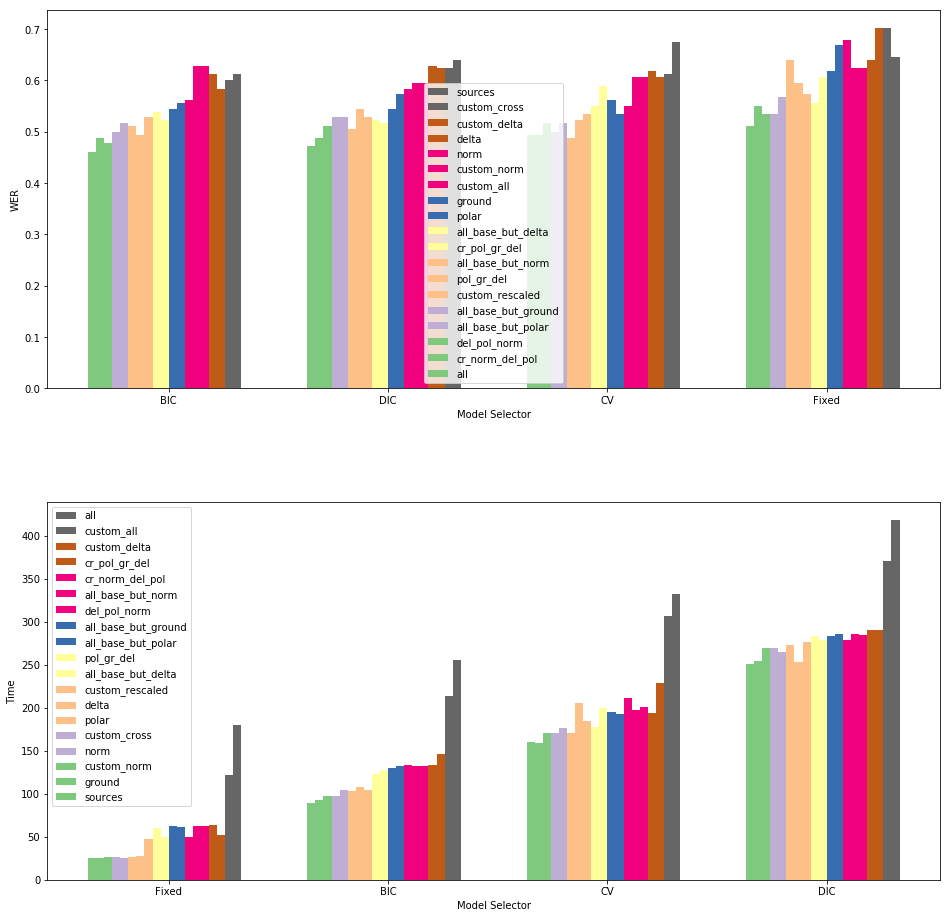

In [39]:
fig = plt.figure(figsize=(16, 16))
wer = fig.add_subplot(211)
time = fig.add_subplot(212)

barplot(wer, wer_list, "WER", "Model Selector")
barplot(time, time_list, "Time", "Model Selector")
plt.subplots_adjust(hspace=0.3)

plt.show()

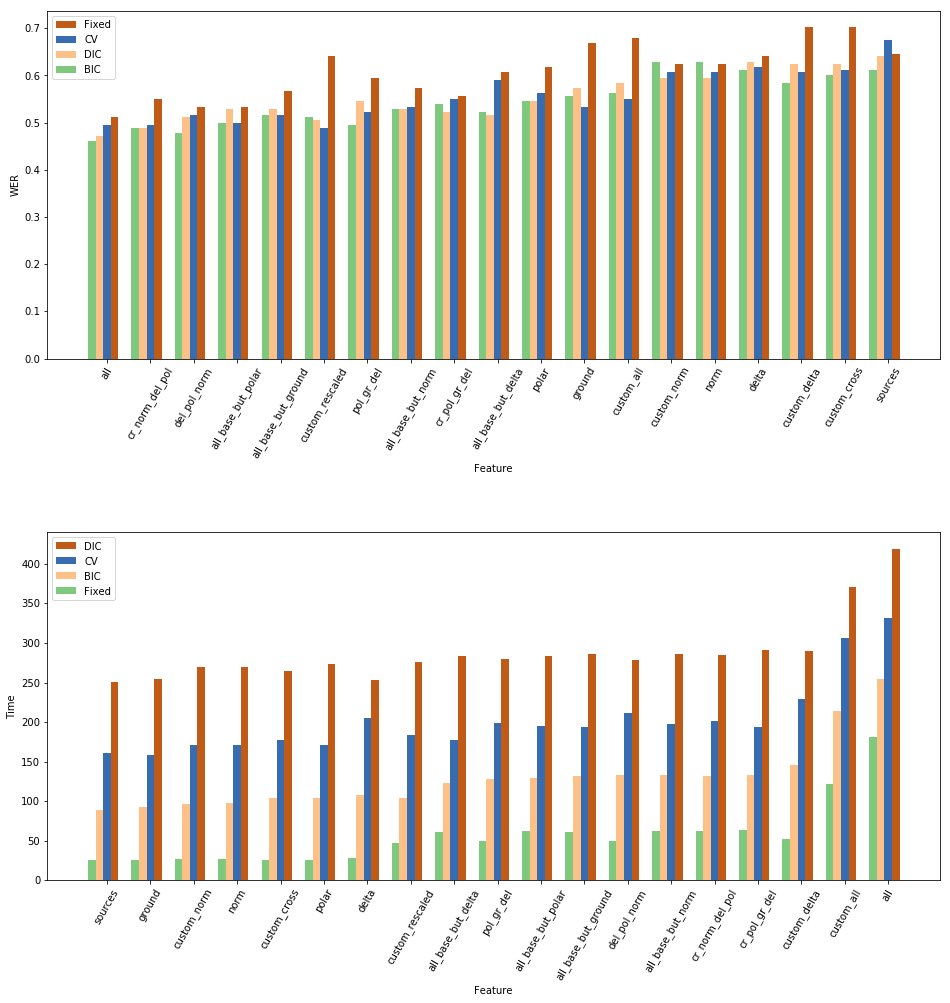

In [40]:
ifig = plt.figure(figsize=(16, 16))
iwer = ifig.add_subplot(211)
itime = ifig.add_subplot(212)

barplot(iwer, i_wer_list, "WER", "Feature")
barplot(itime, i_time_list, "Time", "Feature")

plt.subplots_adjust(hspace=0.5)
plt.setp(iwer.get_xticklabels(), rotation=60)
plt.setp(itime.get_xticklabels(), rotation=60)
plt.show()

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why? What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

The graphs provided above are all ordered by the average of the columns that compose each group. In the first group I'll show a comparison between the model selectors in this context, in the second group I've shown the performances of all the features and features group I've trained the models on.

We can see that BIC is the model selector most performant, giving the best average WER and was the fastest (if we exclude Fixed model).
With the graphs provided we can see that DIC have quite good performances in terms of WER but is taking a lot of time, probably due to the way it is built. He needs to train the model multiple time.

I was surprised by the fact that **norm** and **delta** performed so bad when taken alone, I suspect I have implented them poorly maybe. On the other hands we can see how good **ground** and **polar** performed in terms of both WER and time. 
**Ground** gave his best match with **CV**, probably due to the simple nature of the data, the cross validation was a better match to it.
**Polar** coordinates on the other hands were almost equivalent with **BIC** and **DIC**.

The most time consuming training was by using **all** features, and the best performances was with **BIC**. 
This granted a WER of **0.466** in 200 seconds, BIC in this case was by far the best choice, and DIC showed me that, when the number of feature grows, it start to slow down pretty much
As expected the mix of all features gave the best results, at the price of a big amount of time compared to other simpler features.

Talking about set of features I've seen a weird change of behaviour. Although **ground** and **polar** taken alone seemed the better (base) features, the set of features composed by: **source + norm + delta + ground** performed slightly better than the ones with both **polar** and **ground** inside, similar performances were obtained when ground was replaced with polar. 

This led me to a couple of extra experiment, adding delta to polar and ground, to have speed reference (delta) that represent what happens through time, and static representations that give me the current situation.
Another experiment was **norm + delta + polar** and this lead too to good results.

I tried to add correlation between the two hands by adding the **cross** feature but the extra time didn't gave me the extra performances I hoped for, although it improved the behaviour of **delta+norm+polar**.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [41]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 39.990s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [45]:
import arpa
from asl_utils import wer_calc

# I must build a static import fromthe file 'ngram/probabilities' to avoid re-calculate the first part
import json

#prbs = json.load(open('ngram/probabilities'))
# create a DataFrame of log likelihoods for the test word items
# we will test all the features but just BIC as model selector
feature_set = {
    'ground': features_ground,
    'polar': features_polar,
    'custom_rescaled': features_rescaled,
    'custom_all': features_custom,
    'all': features_custom + features_sources + features_ground + features_delta + features_polar + features_norm,
    'all_base_but_polar': features_sources + features_norm + features_ground + features_delta,
    'cr_pol_gr_del': features_cross + features_polar + features_ground + features_delta,
}
lm = arpa.loadf("ngram/ukn.1.lm")[0]
wer_1g_list = {}
lmf_list = range(-100, 100, 5)
for f in feature_set:
    wer_1g_list[f] = []
    for lmf in lmf_list:
        df_probs = pd.DataFrame(data=probs[f]['BIC'])
        for word in df_probs.columns:
            try:
                df_probs[word] += lmf*lm.log_p(word)
            except:
                df_probs[word] += lmf*lm.log_p(word[:-1])
        guesses = df_probs.idxmax(axis=1).tolist()
        test_set = asl.build_test(feature_set[f])
        w = wer_calc(guesses, test_set)
        # print([f, lmf, w])
        wer_1g_list[f].append(w)
    print("feature {} \tminimize wer with LMF={} \tWER={:.4f}"
          .format(f, lmf_list[np.argmin(wer_1g_list[f])], np.min(wer_1g_list[f])))

feature ground 	minimize wer with LMF=10 	WER=0.5169
feature polar 	minimize wer with LMF=10 	WER=0.5000
feature custom_rescaled 	minimize wer with LMF=-5 	WER=0.5056
feature custom_all 	minimize wer with LMF=15 	WER=0.5506
feature all 	minimize wer with LMF=-75 	WER=0.4551
feature all_base_but_polar 	minimize wer with LMF=20 	WER=0.4944
feature cr_pol_gr_del 	minimize wer with LMF=65 	WER=0.5169


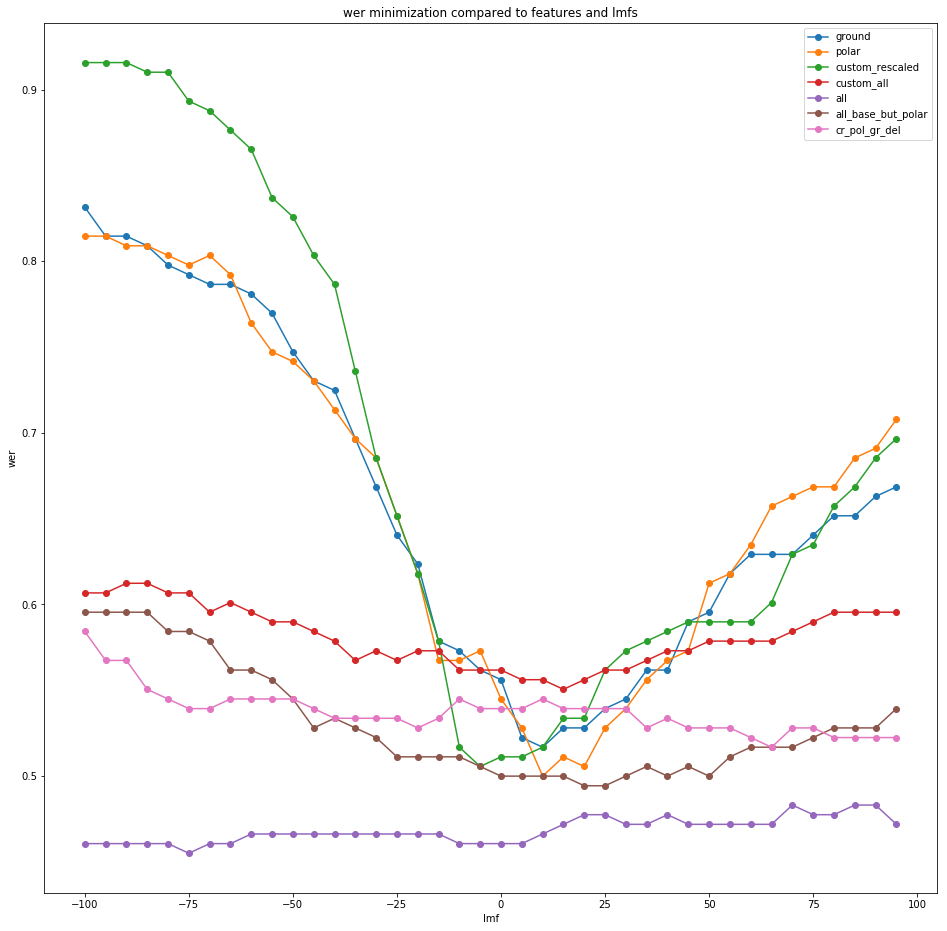

In [44]:
plt.rcParams["figure.figsize"] = [16, 16]
for f in feature_set:
    plt.plot(lmf_list, wer_1g_list[f], marker='o', label=f)

plt.xlabel("lmf")
plt.ylabel("wer")
plt.title("wer minimization compared to features and lmfs")
plt.legend()

plt.show()

We can see how simple features **ground** and **polar** have great benefits from 1-gram informations, where others have little or no benefits at all.
My next step is to implement 2-grams and 3-grams, I hope to be able to do so before the deadline.